Training on the O dataset.

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data Loading

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_O.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_O.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_O.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


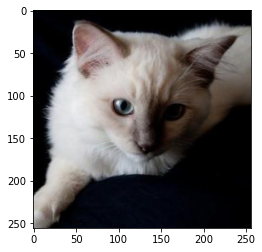

In [3]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model with 6 conv layers

In [4]:
class PetCNN6ch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(1024, 370))
        
        self.dense2 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = self.dense2(out)
        out = nn.functional.log_softmax(out,dim=1)    
        
        return out
    


model1 = PetCNN6ch()
loss_function = nn.NLLLoss()


print(model1)
        




PetCNN6ch(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 25

In [5]:
learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
#iteration_list = []
#train_loss_iter=[]
#train_accuracy_iter=[]
#valid_loss_iter=[]
#valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 65.50493550300598
Epoch:1
Iteration:100
Time taken for the last 50 iterations: 68.59299755096436
Current training loss:3.563302993774414
Current training accuracy:0.06298828125
Current validation loss:3.617192506790161
Current validation accuracy:0.0555555559694767
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 63.313886404037476
Current training loss:3.4626271724700928
Current training accuracy:0.07861328125
Current validation loss:3.5144643783569336
Current validation accuracy:0.07222222536802292
Epoch:2
Iteration:200
Time taken for the last 50 iterations: 62.74427604675293
Current training loss:3.3920559883117676
Current training accuracy:0.0771484375
Current validation loss:3.4364824295043945
Current validation accuracy:0.07222222536802292
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 63.07959985733032
Current training loss:3.408494234085083
Current training accuracy:0.0791015625
Current valida

Current validation loss:2.527223587036133
Current validation accuracy:0.28611111640930176
Epoch:17
Iteration:1750
Time taken for the last 50 iterations: 64.18407917022705
Current training loss:1.3748323917388916
Current training accuracy:0.6201171875
Current validation loss:2.6251938343048096
Current validation accuracy:0.2680555582046509
Epoch:18
Iteration:1800
Time taken for the last 50 iterations: 63.3749897480011
Current training loss:1.3082584142684937
Current training accuracy:0.64208984375
Current validation loss:2.5298871994018555
Current validation accuracy:0.2874999940395355
Epoch:18
Iteration:1850
Time taken for the last 50 iterations: 64.12883472442627
Current training loss:1.228453516960144
Current training accuracy:0.677734375
Current validation loss:2.6014835834503174
Current validation accuracy:0.27916666865348816
Epoch:19
Iteration:1900
Time taken for the last 50 iterations: 63.301509380340576
Current training loss:1.0407401323318481
Current training accuracy:0.7285156

Current training loss:0.21438884735107422
Current training accuracy:0.9609375
Current validation loss:2.6616899967193604
Current validation accuracy:0.32777777314186096
Epoch:34
Iteration:3400
Time taken for the last 50 iterations: 58.88522529602051
Current training loss:0.23301561176776886
Current training accuracy:0.95654296875
Current validation loss:2.674304485321045
Current validation accuracy:0.3513889014720917
Epoch:34
Iteration:3450
Time taken for the last 50 iterations: 61.47174525260925
Current training loss:0.22180777788162231
Current training accuracy:0.97314453125
Current validation loss:2.625924587249756
Current validation accuracy:0.3638888895511627
Epoch:35
Iteration:3500
Time taken for the last 50 iterations: 65.54808497428894
Current training loss:0.18006525933742523
Current training accuracy:0.9716796875
Current validation loss:2.7417516708374023
Current validation accuracy:0.33888888359069824
Epoch:35
Iteration:3550
Time taken for the last 50 iterations: 61.17999100

KeyboardInterrupt: 

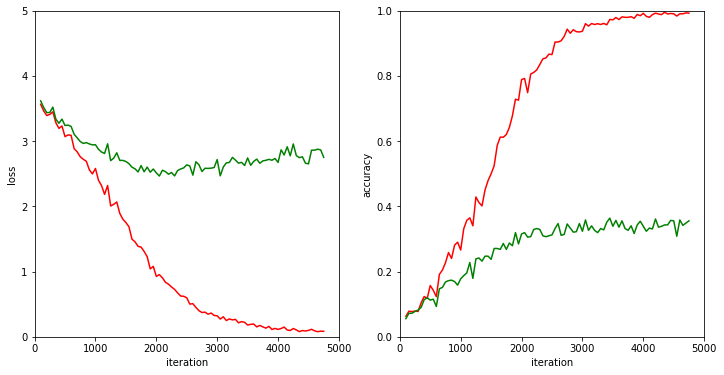

In [6]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,5000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,5000)
acc_graph.set_ylim(0,1)

plt.show() 